# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание проекта:** предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей. Постройте модель машинного обучения, которая поможет определить стоимость автомобиля сервису «Не бит, не крашен». Моделей необходимо несколько, одна из которых  LightGBM.

**Цель исследования:** Необходимо определить стоимость автомобиля.

**Ход исследования:**

- Изучение данных;
- Подготовка данных;
- Обучение моделей;
- Анализ результатов.

**Общий вывод:** резюмирование полуенных результатов, формулировка ключевых выводов и результатов.

In [1]:

!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.7.3 -q
!pip install -q --upgrade numba
!pip install phik -q
!pip install missingno -q
!pip install wordcloud==1.8.2.2 -q
!pip install -q --upgrade Pillow==9.5.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.


In [2]:
# импорты из стандартной библиотеки.
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from phik import phik_matrix
from time import time

# импорты модулей текущего проекта
from catboost import CatBoostRegressor, Pool
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.impute import SimpleImputer
import lightgbm as lgb


# настройки
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
def plot_histograms_boxplots(df):
    """
    Строит гистограммы и ящики с усами для каждого количественного фактора в DataFrame.

    :param df: DataFrame, содержащий данные
    """
    # Выбор числовых столбцов
    numeric_cols = df.select_dtypes(include=['number']).columns

    # Установка размера фигуры
    num_plots = len(numeric_cols)
    plt.figure(figsize=(10, 5 * num_plots))

    # Построение гистограмм и ящиков с усами для каждого числового столбца
    for i, col in enumerate(numeric_cols):
        # Гистограмма
        plt.subplot(num_plots, 2, 2*i + 1)
        df[col].hist(bins=15)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        # Ящик с усами
        plt.subplot(num_plots, 2, 2*i + 2)
        df.boxplot(column=col)
        plt.title(f'Box Plot of {col}')

    plt.tight_layout()
    plt.show()

In [4]:
def plot_countplots(df):
    """
    Строит countplots для каждого категориального фактора в DataFrame.

    :param df: DataFrame, содержащий данные.
    """
    # Выбор категориальных столбцов
    categorical_cols = df.select_dtypes(exclude=['number']).columns

    # Установка размера фигуры
    num_plots = len(categorical_cols)
    plt.figure(figsize=(10, 5 * num_plots))

    # Построение countplots для каждого категориального столбца
    for i, col in enumerate(categorical_cols):
        plt.subplot(num_plots, 1, i + 1)
        sns.countplot(y=col, data=df)
        plt.title(f'График {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')

    plt.tight_layout()
    plt.show()

In [5]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [49]:
RANDOM_STATE = 12345
VALID_SIZE = 0.25
TEST_SIZE = 0.5
TEST_SIZE_rf = 0.2

## Подготовка данных

### Загрузка данных

In [7]:
data_auto = pd.read_csv("/datasets/autos.csv", parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'], dayfirst=True)

In [8]:
data_auto.head(15)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06


### Изучение датафрейма

In [9]:
#Проверим данные на дубликаты.
data_auto.duplicated().sum()

4

In [10]:
data_auto = data_auto.drop_duplicates()
data_auto.duplicated().sum()

0

#### Изучение признаков

In [11]:
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

Названия столбцов написаны без использования змеиного регистра. Исправим.

In [12]:
data_auto.columns = data_auto.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data_auto.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [13]:
#Найдем число уникальных значений в стобце "количество фотографий".
data_auto.number_of_pictures.value_counts()

0    354365
Name: number_of_pictures, dtype: int64

Видно, что данный признак никак не влияет на стоимость машины. Также в данных присутствуют признаки, которые также не влияют на стоимость машины. Удалим их.

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'postal_code']


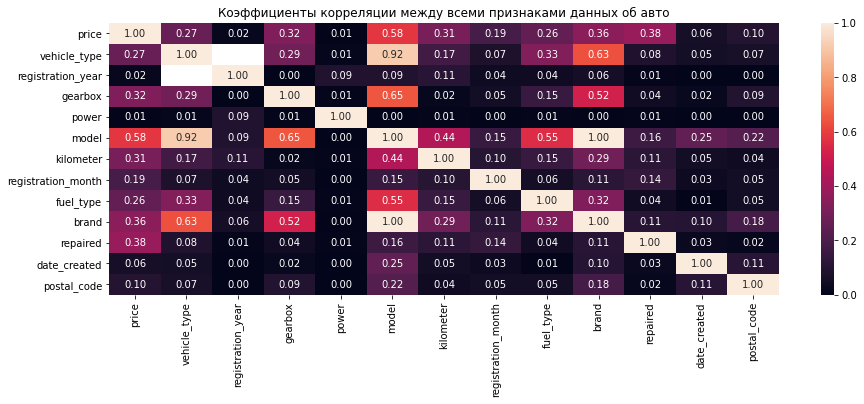

In [14]:
_phik_matrix = data_auto.drop(['number_of_pictures', 'date_crawled', 'last_seen'], axis=1).phik_matrix()
plt.figure(figsize=(15, 5))
sns.heatmap(_phik_matrix, annot=True, fmt=".2f");
plt.title('Коэффициенты корреляции между всеми признаками данных об авто');

In [15]:
data_auto = data_auto.drop(['number_of_pictures', 'postal_code', 'date_created', 'last_seen',
                  'registration_month', 'date_crawled'], axis=1)

In [16]:
data_auto.head(15)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


#### Изучение данных

In [17]:
data_auto.describe()

,price,registration_year,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [18]:
# найдем количество пропусков.
data_auto.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

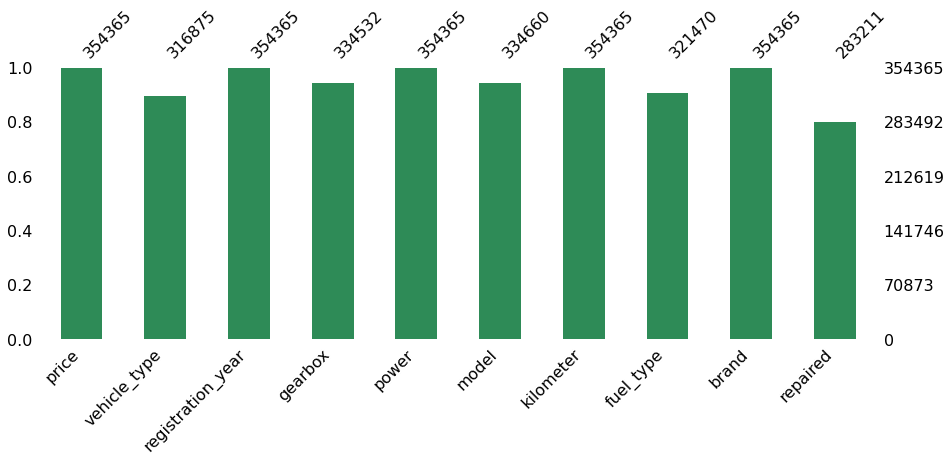

In [19]:
msno.bar(data_auto, figsize=(15, 5), color="seagreen");

In [20]:
# найдем уникальные значения столбцов с пропусками.
for column in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']:
    print(f'{column}\n{data_auto[column].value_counts()}\n')

vehicle_type
sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

gearbox
manual    268249
auto       66283
Name: gearbox, dtype: int64

model
golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

fuel_type
petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

repaired
no     247158
yes     36053
Name: repaired, dtype: int64



In [21]:
# В столбце "тип топлива" заменим 'gasoline' на 'petrol'.
data_auto['fuel_type'] = data_auto['fuel_type'].replace({'gasoline': 'petrol'})

In [22]:
#Заменим пропуски на значение "другие", т.к. данная категория присутствует в некоторых признаках.
imp = SimpleImputer(strategy="constant", fill_value='other')
_data_auto_tr = pd.DataFrame(imp.fit_transform(data_auto))
_data_auto_tr.columns = data_auto.columns
_data_auto_tr.index = data_auto.index
data_auto[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']] \
= _data_auto_tr[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']]

In [23]:
# посмотрим на результат работы с пропусками.
for column in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']:
    print(f'{column}\n{data_auto[column].value_counts()}\n')

vehicle_type
sedan          91457
small          79830
wagon          65165
other          40778
bus            28775
convertible    20203
coupe          16161
suv            11996
Name: vehicle_type, dtype: int64

gearbox
manual    268249
auto       66283
other      19833
Name: gearbox, dtype: int64

model
other                 44125
golf                  29232
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

fuel_type
petrol      315068
other        33099
lpg           5310
cng            565
hybrid         233
electric        90
Name: fuel_type, dtype: int64

repaired
no       247158
other     71154
yes       36053
Name: repaired, dtype: int64



In [24]:
data_auto.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [25]:
#Проверим столбец "марка" на уникальные значения.
data_auto.brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

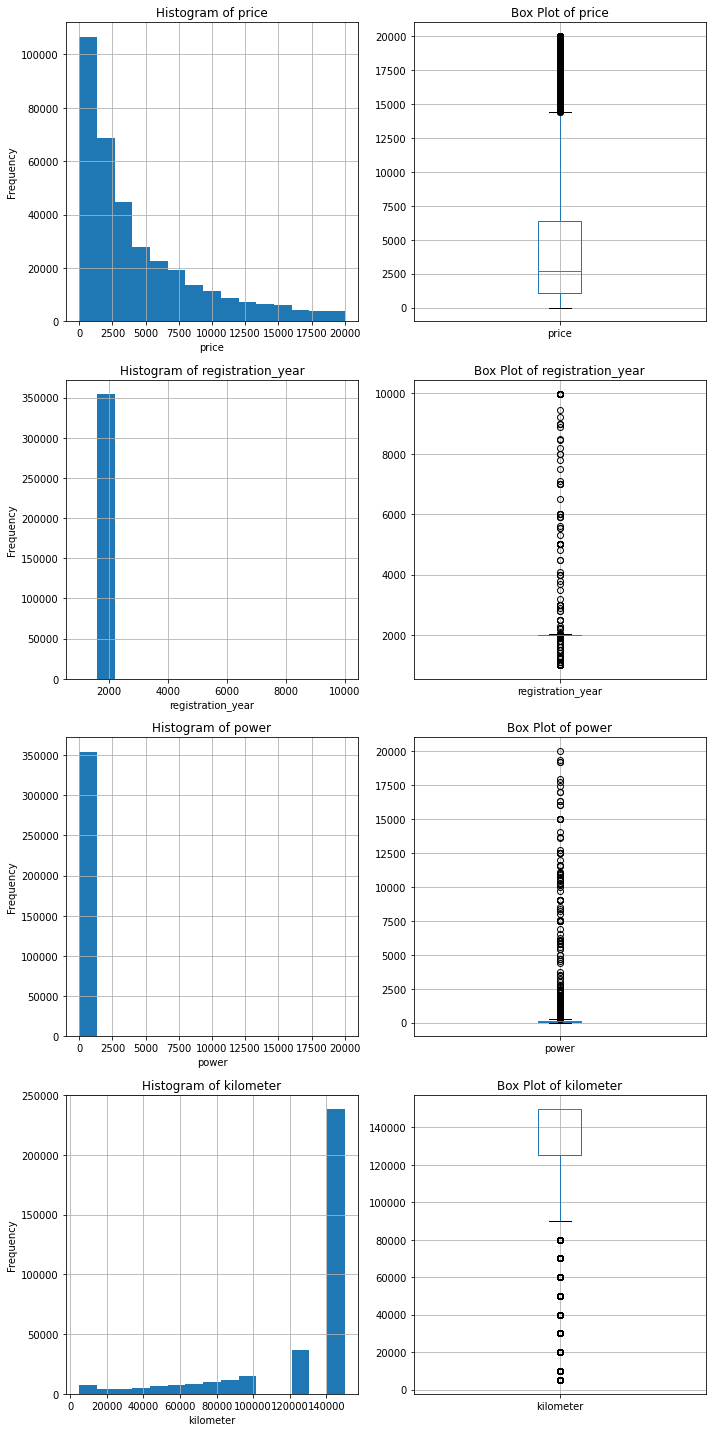

In [26]:
#Посмотрим на количественные данные.
plot_histograms_boxplots(data_auto)

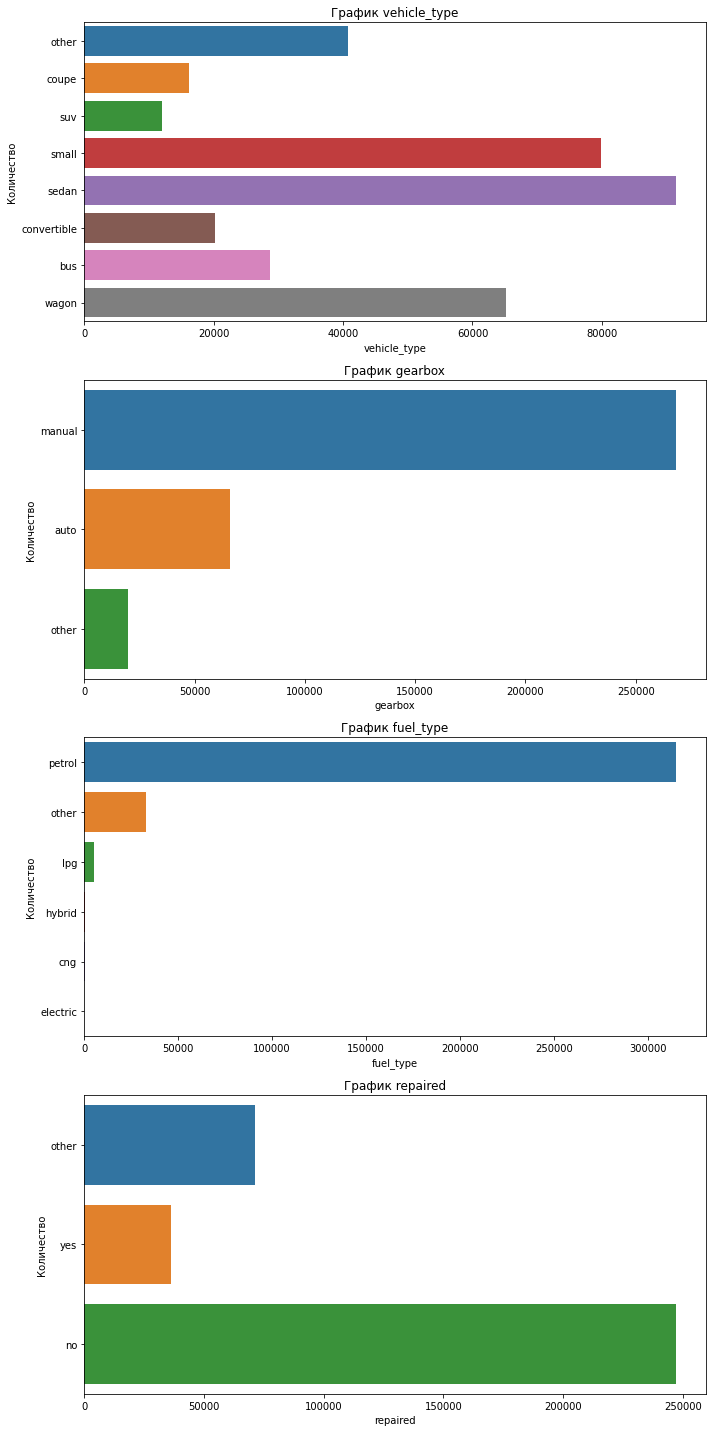

In [27]:
#Посмотрим на категориальные данные.
plot_countplots(data_auto.drop(['brand', 'model'], axis=1))

In [28]:
#Для столбца "цена" характерны вбросы после ~15 000. Отбросим их, а также уберем нулевые стоимости. 
#Сделаем срез данных по квантилям .05 и .95.
data_auto.price.quantile([.05, 0.95])
data_auto = data_auto.query('350 <= price <= 14800')

In [29]:
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310892 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              310892 non-null  int64 
 1   vehicle_type       310892 non-null  object
 2   registration_year  310892 non-null  int64 
 3   gearbox            310892 non-null  object
 4   power              310892 non-null  int64 
 5   model              310892 non-null  object
 6   kilometer          310892 non-null  int64 
 7   fuel_type          310892 non-null  object
 8   brand              310892 non-null  object
 9   repaired           310892 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.1+ MB


In [30]:
#Для столбца "дата регистрации авто" сделаем срез по 2016 году и нижнюю границу выберем по 1980 году,
#Т.к старше авто могут оказаться раритетными и некорректно сравнивать их стоимость с обычными машинами.
data_auto = data_auto.query('1980 <= registration_year <= 2016')

In [31]:
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295239 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              295239 non-null  int64 
 1   vehicle_type       295239 non-null  object
 2   registration_year  295239 non-null  int64 
 3   gearbox            295239 non-null  object
 4   power              295239 non-null  int64 
 5   model              295239 non-null  object
 6   kilometer          295239 non-null  int64 
 7   fuel_type          295239 non-null  object
 8   brand              295239 non-null  object
 9   repaired           295239 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.8+ MB


In [32]:
#Для столбца "мощность" сделаем срез по нижней границе мощности 9 л.с. (авто Citroën 2CV) и по верхней 3500 л.с. (авто БелАЗ).
data_auto = data_auto.query('9 <= power <= 3500')

In [33]:
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268364 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              268364 non-null  int64 
 1   vehicle_type       268364 non-null  object
 2   registration_year  268364 non-null  int64 
 3   gearbox            268364 non-null  object
 4   power              268364 non-null  int64 
 5   model              268364 non-null  object
 6   kilometer          268364 non-null  int64 
 7   fuel_type          268364 non-null  object
 8   brand              268364 non-null  object
 9   repaired           268364 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.5+ MB


In [34]:
#Посмотрим корреляцию признаков.
data_auto.corr()

,price,registration_year,power,kilometer
price,1.000000,0.551955,0.352014,-0.338520
registration_year,0.551955,1.000000,0.056315,-0.328387
power,0.352014,0.056315,1.000000,0.125704
kilometer,-0.338520,-0.328387,0.125704,1.000000


interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


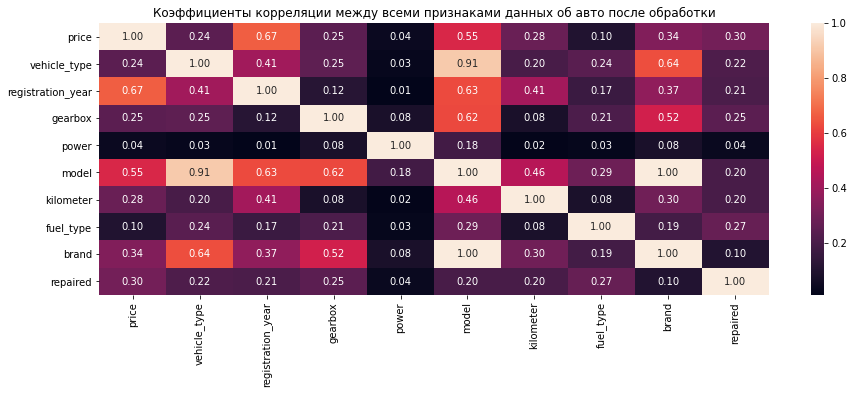

In [36]:
_phik_matrix = data_auto.phik_matrix()
plt.figure(figsize=(15, 5))
sns.heatmap(_phik_matrix, annot=True, fmt=".2f");
plt.title('Коэффициенты корреляции между всеми признаками данных об авто после обработки');

**Выводы к разделу:**
- Пропуски были только в категорийных признаках. Замену выполнили по категориям "другие" и "неизвестно";
- Дубликаты объектов: было найдено 4 дубликата - удалены;
- Проверена корреляция: все в рамках разумных пределов, наиболее коррелирующим с целевым признаком является признак отвечающий за год регистрации авто;
- Данные были очищены от выбросов, суммарно было удалено 86 004 объектов, что составляет около 24%. Это достаточно большой процент, поэтому в случае низких результатов модели имеет смысл изменить(увеличить) пределы срезов, что уменьшит общий объем объектов идентифицирующих как выбросы.

In [37]:
data_auto_opt = optimize_memory_usage(data_auto)
data_auto_opt.info()

Размер использования памяти: до 22.52 Mb - после 16.89 Mb (25.0%)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 268364 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              268364 non-null  int16 
 1   vehicle_type       268364 non-null  object
 2   registration_year  268364 non-null  int16 
 3   gearbox            268364 non-null  object
 4   power              268364 non-null  int16 
 5   model              268364 non-null  object
 6   kilometer          268364 non-null  int32 
 7   fuel_type          268364 non-null  object
 8   brand              268364 non-null  object
 9   repaired           268364 non-null  object
dtypes: int16(3), int32(1), object(6)
memory usage: 16.9+ MB


## Обучение моделей

In [38]:
#Разделим датасет на тренировочную, валидационную и тестовую выборки.
features = data_auto_opt.drop(['price'], axis=1)
target = data_auto_opt['price']

X_train, X_valid, y_train, y_valid = train_test_split(
    features, target, test_size=VALID_SIZE, random_state=RANDOM_STATE
)

X_test, X_valid, y_test, y_valid = train_test_split(
    features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [41]:
#Подготовим категориальные признаки для моделей Catboost, RandomForest и LightGBM.
ohe_features = X_train.select_dtypes(include='object').columns.to_list()

#Подготовим количественные признаки для моделей Catboost, RandomForest и LightGBM.
num_features = X_train.select_dtypes(exclude='object').columns.to_list()

### Модель CatBoost

In [39]:
X_train_cb = X_train.copy()
y_train_cb = y_train.copy()

In [42]:
start = time()

catboost = CatBoostRegressor(loss_function='RMSE')
parameters_cat = [{'learning_rate':[0.1,0.4,0.9], 'random_state':[RANDOM_STATE]}]
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(X_train_cb, y_train_cb, cat_features=ohe_features), cv=3, verbose=True, plot=False)

end = time()

_cb_time = (end-start)/60
_cb_time

0:	learn: 5106.5754451	test: 5076.8938507	best: 5076.8938507 (0)	total: 355ms	remaining: 5m 54s
1:	learn: 4691.7665200	test: 4665.2073827	best: 4665.2073827 (1)	total: 604ms	remaining: 5m 1s
2:	learn: 4327.6429562	test: 4303.7871399	best: 4303.7871399 (2)	total: 764ms	remaining: 4m 13s
3:	learn: 3996.6040445	test: 3974.2328812	best: 3974.2328812 (3)	total: 991ms	remaining: 4m 6s
4:	learn: 3709.1470672	test: 3688.8352794	best: 3688.8352794 (4)	total: 1.21s	remaining: 4m
5:	learn: 3447.9869710	test: 3431.7863921	best: 3431.7863921 (5)	total: 1.45s	remaining: 4m
6:	learn: 3215.5430829	test: 3200.2638706	best: 3200.2638706 (6)	total: 1.65s	remaining: 3m 54s
7:	learn: 3015.2847517	test: 3000.4406905	best: 3000.4406905 (7)	total: 1.85s	remaining: 3m 49s
8:	learn: 2830.5265196	test: 2816.6803918	best: 2816.6803918 (8)	total: 2.08s	remaining: 3m 48s
9:	learn: 2671.6377885	test: 2658.5653343	best: 2658.5653343 (9)	total: 2.26s	remaining: 3m 43s
10:	learn: 2532.8164629	test: 2520.7038968	best: 2

20.30690509478251

In [43]:
catboost_grid["params"]

{'random_seed': 12345, 'learning_rate': 0.4}

In [44]:
start = time()

final_cat = CatBoostRegressor(random_seed=catboost_grid["params"]["random_seed"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(X_train_cb, y_train_cb, cat_features=ohe_features))

end = time()

cb_time = ((end-start)/60)+_cb_time
cb_time

0:	learn: 2776.8232033	total: 261ms	remaining: 4m 20s
100:	learn: 1345.3292158	total: 19.6s	remaining: 2m 54s
200:	learn: 1300.7019125	total: 40s	remaining: 2m 39s
300:	learn: 1274.3935906	total: 1m	remaining: 2m 20s
400:	learn: 1256.5151053	total: 1m 20s	remaining: 2m
500:	learn: 1242.4575995	total: 1m 40s	remaining: 1m 40s
600:	learn: 1229.8501908	total: 2m 1s	remaining: 1m 20s
700:	learn: 1218.9613229	total: 2m 21s	remaining: 1m
800:	learn: 1210.4681216	total: 2m 42s	remaining: 40.3s
900:	learn: 1203.1436905	total: 3m 2s	remaining: 20s
999:	learn: 1195.9290186	total: 3m 22s	remaining: 0us


23.730712362130483

In [74]:
#Замерим время предсказания модели.
start = time()

y_cat_pred = final_cat.predict(X_valid)

end = time()

cb_time_p = (end-start)/60
cb_time_p

0.02706718842188517

In [48]:
#Посмотрим метрику модели.
rmse_cb = mean_squared_error(y_valid, y_cat_pred, squared=False)
rmse_cb

1250.1970789196052

### Модель RandomForest

In [54]:
#Подготовим выборки для модели.
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    features, target, test_size=TEST_SIZE_rf, random_state=RANDOM_STATE
)

In [53]:
#Создадим пайплайн для модели RandomForest.
col_transformer_rf= make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        ohe_features
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough'
)

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestregressor__n_estimators': range(50, 201, 50),
    'randomforestregressor__min_samples_split': (2, 3, 4)
}

# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает на много быстрее
gs_rf = RandomizedSearchCV(
    pipline_rf,
    param_distributions=param_grid_rf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

gs_rf.fit(X_train_rf, y_train_rf)

_res = (
    pd.DataFrame({
        "mean_test_score": gs_rf.cv_results_["mean_test_score"],
        "mean_fit_time": gs_rf.cv_results_["mean_fit_time"],
        "mean_score_time": gs_rf.cv_results_["mean_score_time"]})\
    .join(pd.io.json.json_normalize(gs_rf.cv_results_["params"]).add_prefix("param_"))
)

gs_rf_best_score = gs_rf.best_score_ * -1
gs_rf_best_params = gs_rf.best_params_
rf_time = _res['mean_fit_time'].iloc[gs_rf.best_index_]
rf_time_p = _res['mean_score_time'].iloc[gs_rf.best_index_]
print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')
print(f'model_predict_time: {rf_time} и {rf_time_p}')

best_score: 1316.529069670546
best_params: {'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_split': 4}
model_predict_time: 74.30144057273864 и 3.0353393077850344


### Модель LightGBM

In [67]:
#Подготовим выборки для модели.
X_train_lg = X_train.copy().astype({'vehicle_type':'category',
                                  'gearbox':'category',
                                  'model':'category',
                                  'fuel_type':'category',
                                  'brand':'category',
                                  'repaired':'category'})
X_valid_lg = X_valid.copy().astype({'vehicle_type':'category',
                                  'gearbox':'category',
                                  'model':'category',
                                  'fuel_type':'category',
                                  'brand':'category',
                                  'repaired':'category'})
y_train_lg = y_train.copy()

In [68]:
start = time()

model_lg = lgb.LGBMRegressor() 
parameters = [{'num_leaves':[100, 150], 'learning_rate':[0.2, 0.4, 0.5, 0.8], 'n_estimators': [50, 100, 150],
               'random_state':[RANDOM_STATE]}]

rs_lg = RandomizedSearchCV(model_lg, parameters, scoring='neg_mean_squared_error')
rs_lg.fit(X_train_lg, y_train_lg)

end = time()
_lg_time = (end-start)/60
_lg_time

7.441182998816172

In [69]:
rs_lg.best_params_

{'random_state': 12345,
 'num_leaves': 150,
 'n_estimators': 150,
 'learning_rate': 0.2}

In [70]:
#Обучим модель на лучших параметрах и посчитаем время обучения.
start = time()

final_model_lg = lgb.LGBMRegressor(num_leaves=rs_lg.best_params_['num_leaves'],
                                   learning_rate=rs_lg.best_params_['learning_rate'],
                                   n_estimators=rs_lg.best_params_['n_estimators'],
                                   random_state=rs_lg.best_params_['random_state']
                                  )
final_model_lg.fit(X_train_lg, y_train_lg)

end = time()
lg_time = ((end-start)/60)+_lg_time
lg_time

7.684366222222646

In [73]:
#Замерим время предсказания модели.
start = time()

y_lg_pred = final_model_lg.predict(X_valid_lg)

end = time()

lg_time_p = (end-start)/60
lg_time_p

0.035985771814982095

In [75]:
#Посмотрим метрику модели.
rmse_lg = mean_squared_error(y_valid, y_lg_pred, squared=False)
rmse_lg

1184.1258412065315

In [78]:
#Сделаем сравнение моделей.
_data = {'RMSE_обучения':[rmse_cb, gs_rf_best_score, rmse_lg],
        'Время обучения модели':[cb_time, rf_time, lg_time],
        'Время предсказания модели':[cb_time_p, rf_time_p, lg_time_p]
       }
_index = ['CatBoost',
         'RandomForest',
         'LightGBM',
        ]


data_rmse = pd.DataFrame(data=_data, index=_index)
print(data_rmse)

              RMSE_обучения  Время обучения модели  Время предсказания модели
CatBoost        1250.197079              23.730712                   0.027067
RandomForest    1316.529070              74.301441                   3.035339
LightGBM        1184.125841               7.684366                   0.035986


**Выводы к разделу:**
Основываясь на полученных результатах можно сделать вывод, что на тренировку CatBoost ушло ~23min, в то же время на обучение рандомного леса ушло ~74min, а на обучение LightGBM ушло всего ~7min. Ошибки моделей не сильно отличаются. В условии указано, что решающим факторами при выборе модели являются следующие показатели:

- Время обучения;
- Время предсказания;
- Качество предсказаний.

Основываясь на данных признаков мы можем из удалить из сравнения RandomForest, так как его время обучения в разы больше, а также RMSE много больше, чем у других моделей. LightGBM обучается быстрее, но предсказывает медленней. Менее выгодно всего в данном случае смотреться CatBoost, эта модель проигрывает по 2 из 3 параметров:

- Время предсказания больше (0.027 m против 0.036 m у LightGBM);
- Качество предсказаний выше (1250 против 1184 у LightGBM);
- Время обучения меньше (74m против 7m у LightGBM).

Основываясь на этом, можно сделать вывод, что лучше всего подойдет модель построенная на LightGBM

## Анализ моделей

In [67]:
#Подготовим выборки для модели.
X_test_lg = X_test.copy().astype({'vehicle_type':'category',
                                  'gearbox':'category',
                                  'model':'category',
                                  'fuel_type':'category',
                                  'brand':'category',
                                  'repaired':'category'})
y_test_lg = y_test.copy()

In [81]:
#Замерим качество модели и время её предсказания.
start = time()

print("Качество лучшей модели LightGBM на тестовой выборке:", 
      (mean_squared_error(y_test_lg, final_model_lg.predict(X_test_lg), squared=False)))

end = time()

lg_time_p_test = (end-start)/60
lg_time_p_test

Качество лучшей модели LightGBM на тестовой выборке: 1260.1486878007433


0.014359847704569498

## Общие выводы

1. Входные данные размером 354 тыс. строк сокращены до 268 тыс. строк, т.к. имелись вбросы и дубликаты;
2. Наиболее коррелирующим с целевым признаком является признак отвечающий за год регистрации авто;
3. После обучения моделей CatBoost, RandomForest и LightGBM выявлено следующее:
- Самое быстрое время предсказания имеет CatBoost 0.027min;
- Самое худшее предсказание имеет RandomForest 1316;
- LightGBM имеет самые минимальные время обучения и качество предсказания ~ 7min и 1184.

Исходя из начальных условий лучше всего подойдет построенная модель на LightGBM, которая на тестовой выборке показало качество 1260, а время предсказания 0.014m.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей